In [ ]:
!pip install drake

In [2]:
import numpy as np
import pydot
from IPython.display import SVG, display, HTML
from pydrake.all import (
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    Simulator,
    plot_system_graphviz
)

import requests
r = requests.get("https://raw.githubusercontent.com/wei-chen-li/wei-chen-li.github.io/main/content/post/triple-pendulum-swingup/notebooks/utils.py")
exec(r.text)

In [ ]:
class CartMultiPendulumStabilizingController(LeafSystem):
    def __init__(self, cart_multi_pendulum: Diagram, configuration: list[str], Q, R):
        """A linaer system of the cart_multi_pendulum at the configuration

        Args:
            cart_multi_pendulum: system returned by `CartMultiPendulumSystem`
            configuration: e.g, ['up', 'down', ...]
            Q: LQR Q matrix
            R: LQR R matrix
        """
        LeafSystem.__init__(self)
        num_states = cart_multi_pendulum.num_continuous_states()
        num_pendulums = (num_states // 2) - 1
        if num_pendulums != len(configuration):
            raise RuntimeError(f"Number of configurations shold be {num_pendulums}, but got {len(configuration)}")

        x0 = CartMultiPendulumEquilibriumState(configuration)
        u0 = np.zeros(1)

        T_j2w = _CartMultiPendulumJoint2World(num_states)
        Q = T_j2w.transpose() @ Q @ T_j2w

        context = cart_multi_pendulum.CreateDefaultContext()
        cart_multi_pendulum.GetMutableSubsystemState(cart_multi_pendulum.GetSubsystemByName('plant'), context).get_mutable_continuous_state().SetFromVector(x0)
        cart_multi_pendulum.get_input_port(0).FixValue(context, u0)

        linear_plant = Linearize(cart_multi_pendulum, context)
        A = linear_plant.A()
        B = linear_plant.B()

        K, _ = LinearQuadraticRegulator(A, B, Q, R)

        self.K, self.x0, self.u0 = K, x0, u0
        self.DeclareVectorInputPort("x", num_states)
        self.DeclareVectorOutputPort("f_cart", 1, self.DoCalcOutput)

    def DoCalcOutput(self, context, output):
        num_states = len(self.x0)
        x = self.get_input_port().Eval(context)
        delta_x = x - self.x0
        delta_x[1:num_states//2] = self.wrap_to_pi(delta_x[1:num_states//2])
        u = self.u0 - self.K @ delta_x
        output.SetFromVector(u)

    @staticmethod
    def wrap_to_pi(angle):
        return (angle + np.pi) % (2 * np.pi) - np.pi

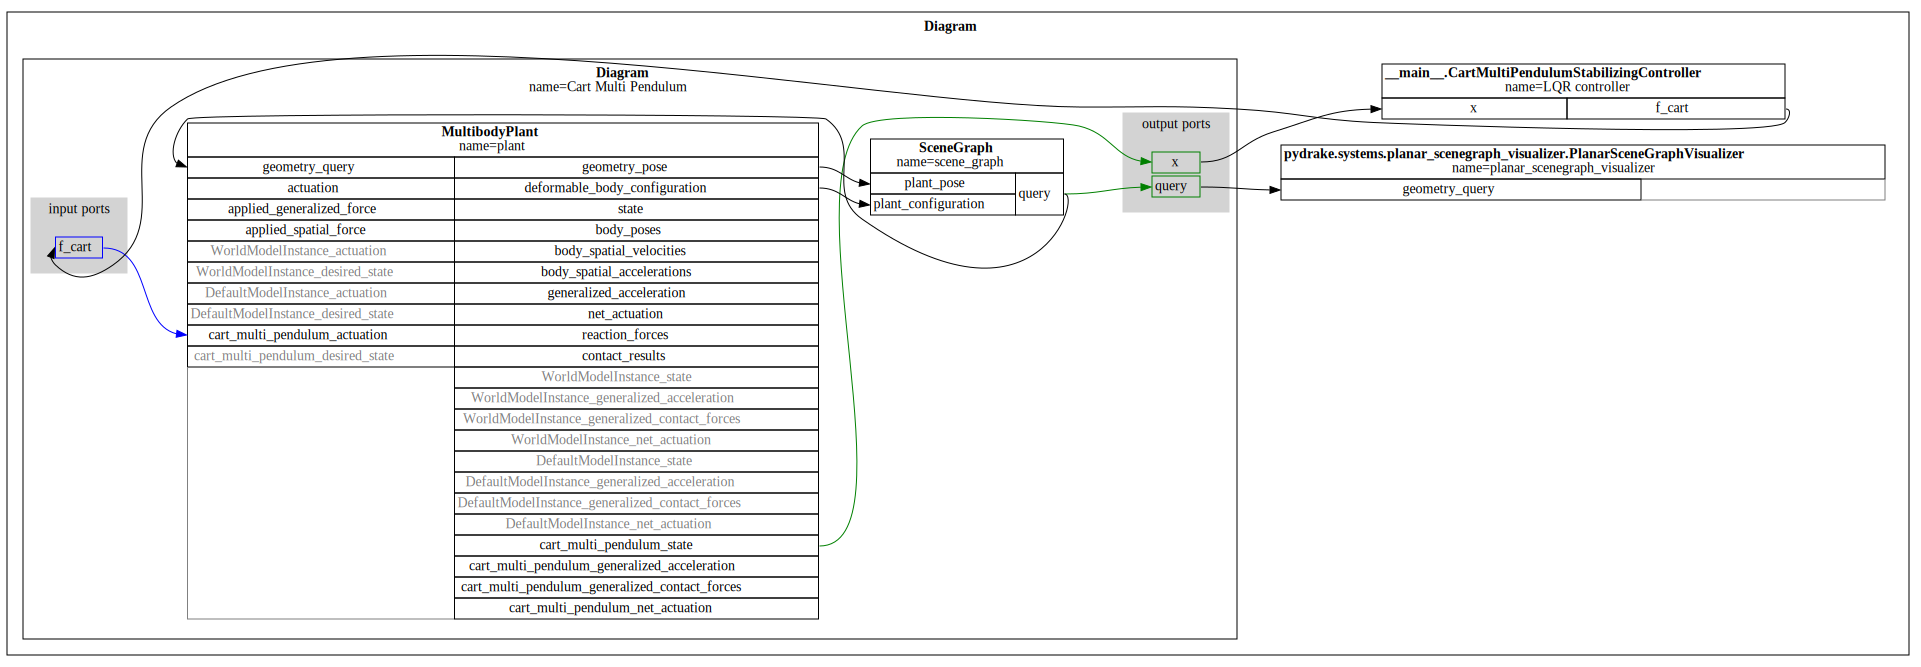

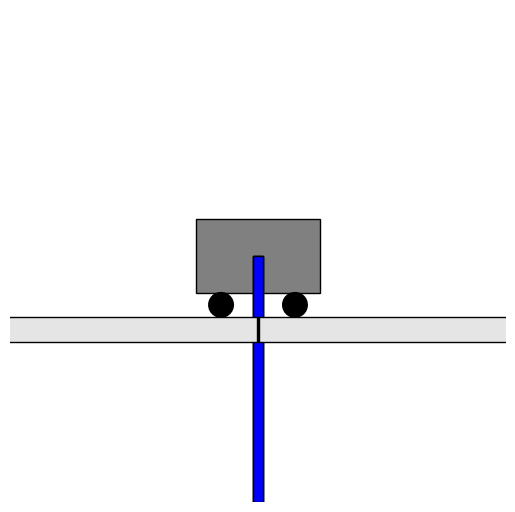

In [3]:
cart_multi_pendulum = CartMultiPendulumSystem(m1=1,l1=1, m2=1,l2=1, m3=1,l3=1)

configuration = ['down', 'up', 'up']

Q = np.diag( [10] * (1+len(configuration)) + [1] * (1+len(configuration)) )
R = np.diag([1])
controller = CartMultiPendulumStabilizingController(cart_multi_pendulum, configuration, Q, R)

builder = DiagramBuilder()
builder.AddNamedSystem("Cart Multi Pendulum", cart_multi_pendulum)
builder.AddNamedSystem("LQR controller", controller)

builder.Connect(cart_multi_pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), cart_multi_pendulum.get_input_port(0))

visualizer = ConnectPlanarSceneGraphVisualizer(builder,
                cart_multi_pendulum.GetSubsystemByName("scene_graph"), cart_multi_pendulum.get_output_port(1))

diagram = builder.Build()

plot_system_graphviz(diagram)
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [4]:
simulator = Simulator(diagram)

x0 = CartMultiPendulumEquilibriumState(configuration)
x0[0] = -1

context = simulator.get_mutable_context()
context.SetTime(0.0)
context.SetContinuousState(x0)

simulator.Initialize()
visualizer.start_recording()
simulator.AdvanceTo(10)
visualizer.stop_recording()

/home/william/.local/lib/python3.10/site-packages/pydrake/systems/pyplot_visualizer.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


In [5]:
# visualizer.fig.tight_layout()
visualizer.ax.set_xlim([-1.5, 1.5])
visualizer.ax.set_position([0, 0, 1, 0.94])
visualizer.fig.set_size_inches([6, 4])
jshtml = visualizer.get_recording_as_animation().to_jshtml()
# with open('tmp.html', 'w') as f:
#     f.write(jshtml)
HTML(jshtml)